# PRML 1.2.5-1.2.6 : Polynomial Curve Fitting

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import unicode_literals, print_function
import six
import sys
import os
import math
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

In [2]:
sys.version

'3.6.0 |Anaconda 4.3.0 (x86_64)| (default, Dec 23 2016, 13:19:00) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

## generate sample dataset

In [3]:
def make_truth_data(func=lambda x: x):
    xs = np.linspace(0, 1, num=50, endpoint=True)
    ts = np.vectorize(func)(xs)
    return xs, ts

def make_observed_data(func=lambda x: x, std=0.1):
    xs = np.linspace(0, 1, num=10, endpoint=True)
    ts = np.vectorize(func)(xs) + np.random.normal(0, std, xs.size)
    return xs, ts

def sin(x):
    return np.sin(2*np.pi*x)

#def step(x):
#    return 1.0 if x >= 0.5 and x <= 1.0 else 0.0

xs_truth, ts_truth = make_truth_data(sin)
xs_observ, ts_observ = make_observed_data(sin, std=0.2)

In [4]:
def plot_sample(ax, xs_truth, ys_truth, xs_observ, ts_observ):
    ax.plot(xs_truth, ts_truth, label='truth')
    ax.scatter(xs_observ, ts_observ, color='green', marker='o', label='observation')
    ax.set_xlim(np.min(xs_truth), np.max(xs_truth))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.legend()
    return ax

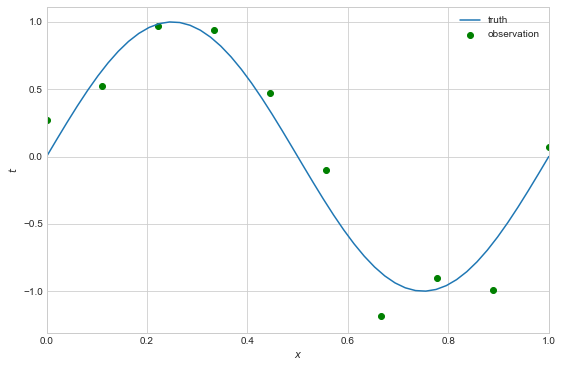

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)

## design matrix

ここでの基底関数は $\phi_{i}(x) = x^{i}$ とする

In [6]:
def poly_features(xs, m=1):
    # formula (3.16)
    return np.asarray([np.power(xs, i) for i in six.moves.range(m+1)]).transpose()

In [7]:
poly_features(xs_observ, m=3)

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.11111111,  0.01234568,  0.00137174],
       [ 1.        ,  0.22222222,  0.04938272,  0.01097394],
       [ 1.        ,  0.33333333,  0.11111111,  0.03703704],
       [ 1.        ,  0.44444444,  0.19753086,  0.0877915 ],
       [ 1.        ,  0.55555556,  0.30864198,  0.17146776],
       [ 1.        ,  0.66666667,  0.44444444,  0.2962963 ],
       [ 1.        ,  0.77777778,  0.60493827,  0.47050754],
       [ 1.        ,  0.88888889,  0.79012346,  0.70233196],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

In [8]:
def plot_prediction(ax, ys_pred, ys_std):
    ax.plot(xs_truth, ys_pred, color='red', label='mean of predictive distribution')
    ax.fill_between(xs_truth, ys_pred-ys_std, ys_pred+ys_std,
                      color='pink', alpha=0.5, label='standard diviation of predictive distribution')
    ax.legend()
    return ax

## maximum likelihood estimation

In [9]:
class MaximumLikelihoodRegression():
    def __init__(self, basis_function=lambda x: x, m=1):
        self.basis_function = basis_function
        self.m = m
        
    def fit(self, xs, ts):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.34) or (3.15)
        self.w_ml = np.linalg.inv(phis.T.dot(phis)).dot(phis.T).dot(ts)
        # formula (3.21)
        self.std_ml = (1./phis.shape[1]) * np.sum(np.power(ts - phis.dot(model.w_ml), 2))
        
    def predict(self, xs):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.31) or (1.1)
        ys = phis.dot(self.w_ml)
        return ys, self.std_ml

ys =  [ 0.0677755   0.2688404   0.44437562  0.59547101  0.72321644  0.82870176
  0.91301684  0.97725151  1.02249566  1.04983912  1.06037176  1.05518344
  1.03536401  1.00200333  0.95619126  0.89901765  0.83157236  0.75494525
  0.67022617  0.57850499  0.48087155  0.37841572  0.27222736  0.16339632
  0.05301245 -0.05783438 -0.16805432 -0.2765575  -0.38225409 -0.4840542
 -0.580868   -0.67160562 -0.75517721 -0.8304929  -0.89646284 -0.95199718
 -0.99600606 -1.02739961 -1.04508798 -1.04798132 -1.03498977 -1.00502347
 -0.95699257 -0.8898072  -0.80237751 -0.69361364 -0.56242573 -0.40772394
 -0.2284184  -0.02341925]
std =  0.112202313031


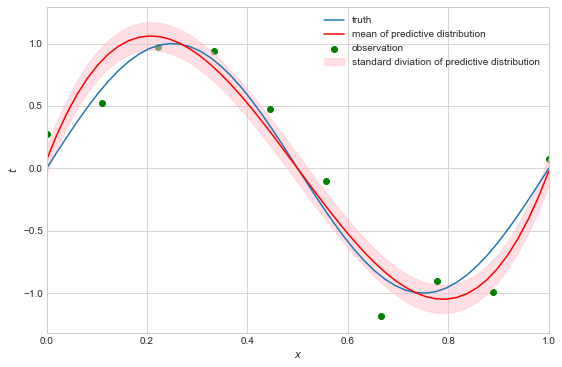

In [10]:
model = MaximumLikelihoodRegression(basis_function=poly_features, m=3)
model.fit(xs_observ, ts_observ)
ys_pred, ys_std = model.predict(xs_truth)
print('ys = ', ys_pred)
print('std = ', ys_std)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, ys_pred, ys_std)

- データに対してオーダーが大きすぎるとover fittingが発生
- 分散も非常に小さい (high bias)

ys =  [ 0.27514324  1.19209893  1.31287978  1.0963217   0.80959661  0.58805888
  0.48120837  0.48705814  0.57695373  0.71266216  0.8573322   0.98172331
  1.06690859  1.10447762  1.09509765  1.04613641  0.96890742  0.87596789
  0.77878135  0.68595113  0.60213753  0.52768998  0.45895663  0.38917724
  0.30982074  0.21219678  0.08915096 -0.06335436 -0.24496643 -0.45015199
 -0.66803693 -0.88298063 -1.07593591 -1.22657895 -1.31611519 -1.33057622
 -1.26431946 -1.12332691 -0.92777162 -0.7131802  -0.52936751 -0.43615487
 -0.49470625 -0.75312746 -1.22477201 -1.85748324 -2.49177625 -2.80572476
 -2.24406709  0.07121749]
std =  1.50144876687e-08


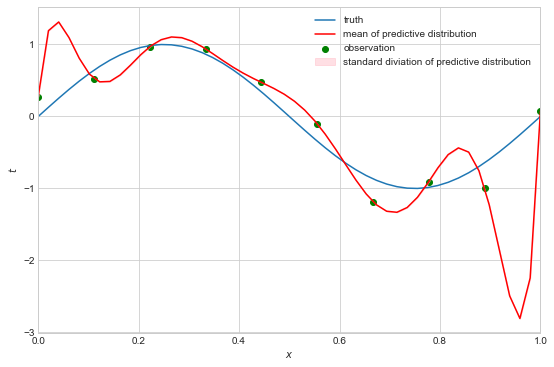

In [11]:
model = MaximumLikelihoodRegression(basis_function=poly_features, m=9)
model.fit(xs_observ, ts_observ)
ys_pred, ys_std = model.predict(xs_truth)
print('ys = ', ys_pred)
print('std = ', ys_std)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, ys_pred, ys_std)

## maximum posterior estimation

結果としては正則化最小二乗法 (§3.1.4) と同様らしいのでその通りに実装 (これで合っている?)

In [12]:
class MaximumPosteriorRegression():
    def __init__(self, basis_function=lambda x: x, m=1, lmd=1):
        self.basis_function = basis_function
        self.m = m
        self.lmd = lmd
    
    def fit(self, xs, ts):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.28)
        self.w_map = np.linalg.inv(self.lmd * np.identity(phis.shape[1]) + phis.T.dot(phis)).dot(phis.T).dot(ts)
        # formula (3.29) or (1.67)
        self.std_map = (1./phis.shape[1]) * np.sum(np.power(ts - phis.dot(model.w_map), 2)) \
                            + (self.lmd/2.) * np.sum(np.power(self.w_map, 2))
        
    def predict(self, xs):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.31) or (1.1)
        ys = phis.dot(self.w_map)
        return ys, self.std_map

ys =  [ 0.3917973   0.49903383  0.59052959  0.66696905  0.72903666  0.77741688
  0.81279416  0.83585296  0.84727773  0.84775294  0.83796304  0.81859248
  0.79032572  0.75384722  0.70984143  0.65899281  0.60198582  0.53950491
  0.47223455  0.40085917  0.32606325  0.24853124  0.16894759  0.08799676
  0.00636321 -0.07526861 -0.15621424 -0.23578922 -0.3133091  -0.38808942
 -0.45944573 -0.52669356 -0.58914847 -0.64612599 -0.69694168 -0.74091106
 -0.77734969 -0.80557312 -0.82489688 -0.83463651 -0.83410757 -0.8226256
 -0.79950613 -0.76406471 -0.7156169  -0.65347822 -0.57696422 -0.48539046
 -0.37807246 -0.25432578]
std =  0.506531722087


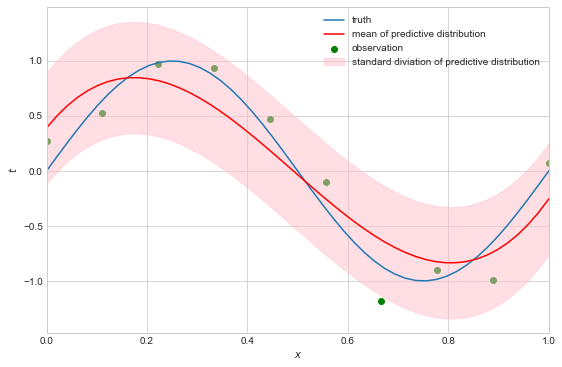

In [13]:
model = MaximumPosteriorRegression(basis_function=poly_features, m=3, lmd=1e-3)
model.fit(xs_observ, ts_observ)
ys_pred, ys_std = model.predict(xs_truth)
print('ys = ', ys_pred)
print('std = ', ys_std)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, ys_pred, ys_std)

- データに対してオーダーが大きくても事前分布(≒正則化)の導入でover fittingを防ぐことができる
- ただし，ベイズ推定のようにパラメータの事後分布を求めている訳ではないので，outlierに弱い場合があるらしい
  - http://ibisforest.org/index.php?MAP推定

ys =  [ 0.29325659  0.38285969  0.46554709  0.54107114  0.60918875  0.66966335
  0.7222672   0.7667838   0.80301079  0.83076299  0.84987587  0.8602093
  0.8616516   0.85412398  0.83758531  0.81203711  0.77752897  0.73416417
  0.68210557  0.62158174  0.55289326  0.4764191   0.39262312  0.30206057
  0.20538444  0.10335173 -0.00317063 -0.11320021 -0.225634   -0.339244
 -0.45267356 -0.56443475 -0.67290672 -0.77633554 -0.87283539 -0.96039164
 -1.03686581 -1.10000278 -1.1474405  -1.17672249 -1.18531342 -1.17061809
 -1.13000415 -1.06082902 -0.96047115 -0.82636631 -0.65604916 -0.44720052
 -0.19770098  0.09430888]
std =  0.10691676908


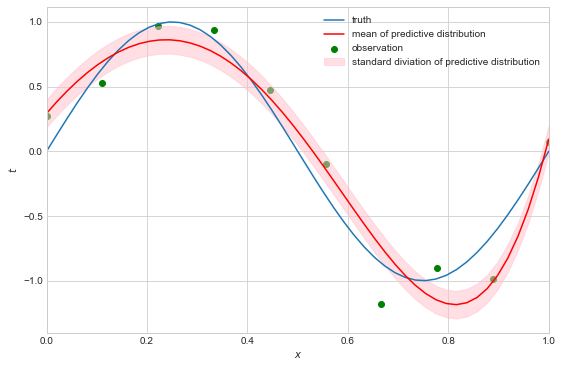

In [14]:
model = MaximumPosteriorRegression(basis_function=poly_features, m=9, lmd=1e-3)
model.fit(xs_observ, ts_observ)
ys_pred, ys_std = model.predict(xs_truth)
print('ys = ', ys_pred)
print('std = ', ys_std)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, ys_pred, ys_std)

## bayesian inference

In [15]:
class BayesianRegression():
    def __init__(self, basis_function=lambda x: x, m=1, alpha=1., beta=1.):
        self.basis_function = basis_function
        self.m = m
        self.alpha = alpha
        self.beta = beta

    def fit(self, xs, ts):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.53) or (1.72)
        cov_inv = self.alpha * np.identity(phis.shape[1]) + self.beta * phis.T.dot(phis)
        self.cov = np.linalg.inv(cov_inv) 
        # formula (3.54) or (1.70)
        self.mean = self.beta * self.cov.dot(phis.T.dot(ts))

    def predict(self, xs):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.58)
        pred_mean = phis.dot(self.mean)
        # formula (3.59)
        pred_cov = (1./self.beta) + np.sum(phis.dot(self.cov.dot(phis.T)), axis=1)
        pred_std = np.sqrt(pred_cov)
        return pred_mean, pred_std

$\alpha$ はテキスト通り $5 \times 10^{-3}$，$\beta$ は$(1/ \sigma)^{2}$ とした ($\sigma$ はサンプルの標準偏差)

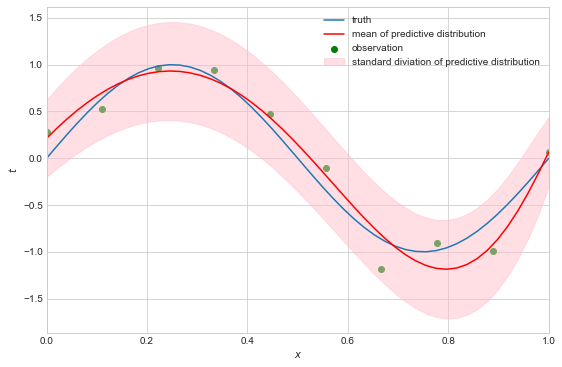

In [16]:
model = BayesianRegression(basis_function=poly_features, m=9, alpha=5e-3, beta=25)
model.fit(xs_observ, ts_observ)
pred_mean, pred_std = model.predict(xs_truth)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, pred_mean, pred_std)